# Dataset

The dataset I chose to use is the *Home Mortgage Disclosure Act (HMDA)* dataset. The dataset's year is 2023 and is filtered for only the state of California.

This dataset has 99 attributes and my end goal is to understand the Denial Rate by Race and Debt-to-Income (DTI), I've narrowed down my dataframe to only use the attributes below:

1. action_taken: The action taken on the covered loan or application
2. debt_to_income_ratio:  The ratio, as a percentage, of the applicant’s or borrower’s total monthly debt to the total monthly income relied on in making the credit decision
3. action_taken: The action taken on the covered loan or application
4. derived_race: Single aggregated race categorization derived from applicant/borrower and co-applicant/co-borrower race fields

## Tasks

1. Create a scorecard including denial rate by race and by debt-to-income (DTI)

2. Visualize to visually analyze and compare the results.


## Table of Contents

1. Exploratory Data Analysis
2. Data Transformation
3. Data Aggregation
4. Analysis
5. Insight Summary
6. Export

## 1. Exploratory Data Analysis

We're checking on the actual data, what is the data, and if the data is clean. This phase loads large, raw HMDA dataset.

In [11]:
import pandas as pd
df = pd.read_csv('p1_loan_data.csv', low_memory=False)
print(df.head())


   activity_year                   lei  derived_msa-md state_code  \
0           2023  549300VZVN841I2ILS84           99999         CA   
1           2023  549300VZVN841I2ILS84           41740         CA   
2           2023  549300VZVN841I2ILS84           31084         CA   
3           2023  549300VZVN841I2ILS84           31084         CA   
4           2023  549300VZVN841I2ILS84           47300         CA   

   county_code  census_tract conforming_loan_limit derived_loan_product_type  \
0       6109.0  6.109004e+09                     C   Conventional:First Lien   
1       6073.0  6.073003e+09                     C             VA:First Lien   
2       6037.0  6.037263e+09                    NC   Conventional:First Lien   
3       6037.0  6.037602e+09                     C   Conventional:First Lien   
4       6107.0  6.107000e+09                     C   Conventional:First Lien   

                derived_dwelling_category        derived_ethnicity  \
0    Single Family (1-4 Units):Sit

In [12]:
#remove limit on columns displayed
pd.set_option('display.max_columns', None)
print(df.head())

   activity_year                   lei  derived_msa-md state_code  \
0           2023  549300VZVN841I2ILS84           99999         CA   
1           2023  549300VZVN841I2ILS84           41740         CA   
2           2023  549300VZVN841I2ILS84           31084         CA   
3           2023  549300VZVN841I2ILS84           31084         CA   
4           2023  549300VZVN841I2ILS84           47300         CA   

   county_code  census_tract conforming_loan_limit derived_loan_product_type  \
0       6109.0  6.109004e+09                     C   Conventional:First Lien   
1       6073.0  6.073003e+09                     C             VA:First Lien   
2       6037.0  6.037263e+09                    NC   Conventional:First Lien   
3       6037.0  6.037602e+09                     C   Conventional:First Lien   
4       6107.0  6.107000e+09                     C   Conventional:First Lien   

                derived_dwelling_category        derived_ethnicity  \
0    Single Family (1-4 Units):Sit

In [13]:
print("There are {} records in the dataset.".format(df.shape[0]))

There are 962073 records in the dataset.


## 2. Data Extraction (E) & Initial Filtering (SQL Simulation) 

This phase simulates a  SQL `SELECT` and `WHERE` clause. By filtering the `action_taken` field to only include finalized decisions (Originated=1, Approved=2, Denied=3). This allows us to ensure the analysis is focused exclusively on the actionable data .


In [14]:
#filter for home purchase applications (action_taken values 1,2,3)

df_filtered = df [ df['action_taken'].isin([1,2,3])].copy()

# 2.1 Data Transformation (T): Feature Engineering & Cleaning

This step cleans and buckets raw data into actionable risk metrics, mimicking Excel's `IF/CASE WHEN` logic:

* **DTI Category:** The granular `debt_to_income_ratio` is categorized into two simple risk segments (`Low/Standard` vs. `High/Watch`) for executive reporting simplicity.
* **Denial Flag:** A binary flag (`Denied`) is created (`np.where` or `if/else`) to allow for simple summation, which is necessary for calculating rates.

We will be creating 'DTI_Category for grouping and creating a 'Denial' metric as well. 37% and higher is a High/Watch, and any number below that is considered Low/Standard.

In [15]:
# creating debt_to_income category for grouping
df_filtered['DTI_Category'] = df_filtered['debt_to_income_ratio'].apply(lambda x: 'Low/Standard' if x in ['<20%', '20%-<30%', '30%-<36%', '36%'] else 'High/Watch') 
# Create denial metric 
df_filtered['Denial'] = df_filtered['action_taken'].apply(lambda x: 1 if x == 3 else 0)

# 3. Data Aggregation (L): The Portfolio Scorecard (Pivot Table)

We will use the  `pandas.groupby().agg()` function to perform the final data summary. This acts as the programmatic equivalent of a  **Excel Pivot Table** or a SQL `GROUP BY` clause, generating the final `scorecard_agg` table.

In [16]:
# This is the simplified Pivot Table equivalent 
scorecard_agg = df_filtered.groupby(['DTI_Category', 'derived_race']).agg( Total_Applications=('action_taken', 'count'), Total_Denials=('Denial', 'sum') ).reset_index()

## 3.1. Calculate Rate (The SUMIFS Logic)

In [17]:
# Calculate the Denial Rate (Denials / Total Applications) 
scorecard_agg['Denial_Rate'] = (scorecard_agg['Total_Denials'] / scorecard_agg['Total_Ap' \
'plications']) * 100 
# Round to one decimal point 
scorecard_agg = scorecard_agg.round(1) 

scorecard_agg

,DTI_Category,derived_race,Total_Applications,Total_Denials,Denial_Rate
0,High/Watch,2 or more minority races,1602,692,43.2
1,High/Watch,American Indian or Alaska Native,4357,1838,42.2
2,High/Watch,Asian,74769,19633,26.3
3,High/Watch,Black or African American,22340,8254,36.9
4,High/Watch,Free Form Text Only,356,175,49.2
5,High/Watch,Joint,14349,3213,22.4
6,High/Watch,Native Hawaiian or Other Pacific Islander,2394,969,40.5
7,High/Watch,Race Not Available,128454,39399,30.7
8,High/Watch,White,234111,63875,27.3
9,Low/Standard,2 or more minority races,385,149,38.7


# 4. Analysis and Critical Deviation Report 

This section generates the primary visual exhibit. We will also extracts the numerical variance statistics needed for executive commentary.

### Exhibit 1: Denial Rate by Race, Grouped by DTI Risk

This visualization shows the interaction between the applicant's risk level (DTI) and demographic group, highlighting where the denial rate is highest and where compliance risks may be concentrated.

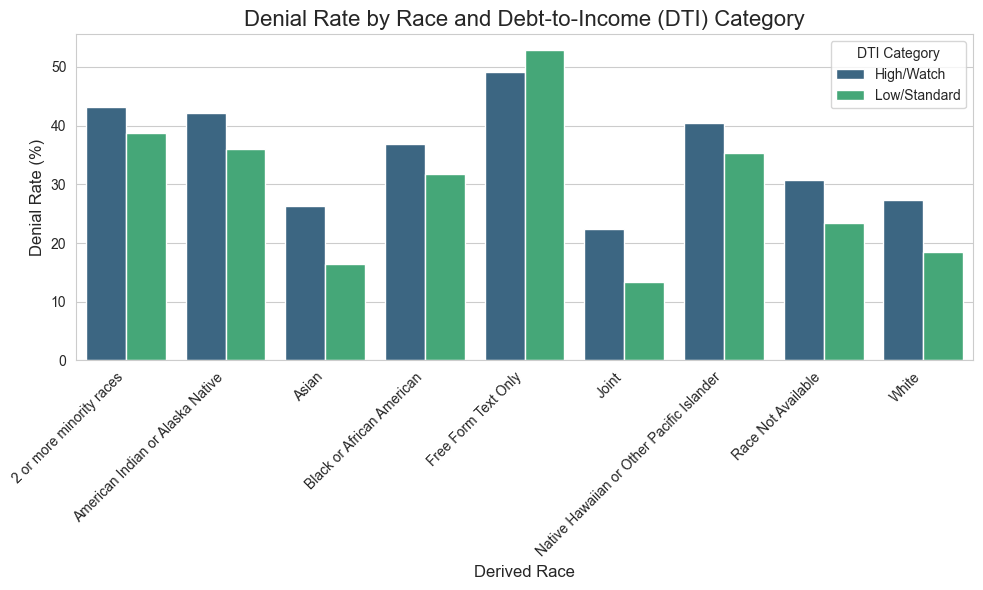

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create Visualization
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create a grouped bar chart to visualize Denial Rate
bar_plot = sns.barplot(
    x='derived_race', 
    y='Denial_Rate', 
    hue='DTI_Category', 
    data=scorecard_agg,  
    palette='viridis' 
)

# Add titles and labels
plt.title('Denial Rate by Race and Debt-to-Income (DTI) Category', fontsize=16)
plt.xlabel('Derived Race', fontsize=12)
plt.ylabel('Denial Rate (%)', fontsize=12)
plt.legend(title='DTI Category')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

# 5. Variance and Policy Insight Summary 

Based on the quantitative findings from the critical deviation statistic (, the following conclusions are drawn:

**CONCLUSION: Segment Risk Deviation**
The highest risk point in the portfolio occurs within the **'Free Form Text Only'** group under the **'Low/Standard'** DTI category, registering a peak denial rate of **52.9%**. This represents a significant variance from the overall portfolio and requires further investigation.

**POLICY RECOMMENDATION:**
The Credit Risk team should initiate a **targeted review** of the underwriting criteria for applicants in the **'Free Form Text Only'** demographic within the **High/Watch Risk** segment. This action is essential to ensure consistent application of the credit model and adherence to Fair Lending compliance standards.


In [19]:
# Find row with single highest denial rate in the ENTIRE scorecard
max_row = scorecard_agg.loc[scorecard_agg['Denial_Rate'].idxmax()]

# Extract specific values for report
max_rate = max_row['Denial_Rate']
max_dti = max_row['DTI_Category']
max_group = max_row['derived_race']

# Print the finding
print("-" * 40)
print("CRITICAL DEVIATION FINDING:")
print(f"The highest Denial Rate is: {max_rate}%")
print(f"This occurs in the '{max_group}' group under the '{max_dti}' risk segment.")
print("-" * 40)

----------------------------------------
CRITICAL DEVIATION FINDING:
The highest Denial Rate is: 52.9%
This occurs in the 'Free Form Text Only' group under the 'Low/Standard' risk segment.
----------------------------------------


# 6. The End. Export.

The final, clean and aggregated scorecard data ('scorecard_agg') exported as a CSV file. This CSV ready for import into any reporting tool for finding visuzalization.

In [20]:
scorecard_agg.to_csv('P1_Exhibit_Final_Scorecard.csv', index=False)
print("Final Scorecard data exported to 'P1_Exhibit_Final_Scorecard.csv'")

Final Scorecard data exported to 'P1_Exhibit_Final_Scorecard.csv'
